In [2]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter
from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties



C:\Users\jhroe\AppData\Local\Temp\ipykernel_10452\2385365580.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# date = datetime.now().strftime("%Y%m%d")

# Get current directory
path = os.getcwd()
data_path = path + '/Data/'

pi = pd.read_excel(f'{data_path}/raw/LUAD Clinical Data.xlsx')

# Set path 
df = pd.read_csv(f"{data_path}/clustering/full_cd_clus_21_40_49.csv").rename(columns={'cluster': 'agglomerateto_275'}).rename(columns={'agglomerateto_40':'cluster'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240506.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID'})

# Merge location data 
df_full= pd.merge(df, df_loc, on='source_ID', how='inner').rename(columns={'agglomerateto_39':'cluster'})


In [4]:
df_full

,Patient_ID,source_ID,source_cluster,Alt.MAC,B,Cancer,Cl_Mac,Cl_Mo,DC,Endothelial,...,Th,Treg,Unknown,agglomerateto_275,agglomerateto_21,cluster,agglomerateto_49,surv_5y,Location_Center_X,Location_Center_Y
0,LUAD_D001,D001_0,Cancer,0.166667,0.0,0.166667,0.166667,0.0,0.0,0.000000,...,0.333333,0.000000,0.000000,1,7,27,27,1,93,159
1,LUAD_D001,D001_1,Tc,0.000000,0.0,0.285714,0.000000,0.0,0.0,0.000000,...,0.285714,0.000000,0.428571,2,17,34,34,1,74,186
2,LUAD_D001,D001_10,Th,0.000000,0.0,0.363636,0.272727,0.0,0.0,0.000000,...,0.090909,0.000000,0.000000,3,5,5,47,1,120,149
3,LUAD_D001,D001_100,Cancer,0.000000,0.0,0.714286,0.000000,0.0,0.0,0.142857,...,0.000000,0.000000,0.142857,4,9,7,3,1,4,407
4,LUAD_D001,D001_1000,Treg,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.083333,...,0.250000,0.000000,0.333333,1,7,27,27,1,782,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637717,LUAD_D416,D416_995,Unknown,0.000000,0.0,0.166667,0.500000,0.0,0.0,0.000000,...,0.166667,0.000000,0.166667,44,3,39,39,1,275,835
1637718,LUAD_D416,D416_996,Cl_Mac,0.000000,0.0,0.400000,0.200000,0.0,0.0,0.000000,...,0.000000,0.000000,0.200000,72,3,3,1,1,110,858
1637719,LUAD_D416,D416_997,Cancer,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.000000,0.333333,0.333333,146,1,31,31,1,153,908
1637720,LUAD_D416,D416_998,Cl_Mac,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.333333,0.000000,0.166667,1,7,27,27,1,155,842


In [5]:
df_pi = pi[['Survival or loss to follow-up (years)', 'Key', 'Death (No: 0, Yes: 1)']].rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=False)
df_pi

,survival,Patient_ID,death
0,8.386,LUAD_D001,1
1,10.111,LUAD_D002,0
2,2.094,LUAD_D003,1
3,1.755,LUAD_D004,1
4,7.598,LUAD_D005,1
...,...,...,...
411,9.944,LUAD_D412,0
412,8.132,LUAD_D413,0
413,8.550,LUAD_D414,0
414,1.862,LUAD_D415,1


In [6]:
treg_clusters_40 = [28, 26, 27, 37, 5, 24, 34, 22, 39, 12]
data = df_full[['Patient_ID', 'cluster', 'surv_5y']]
data

,Patient_ID,cluster,surv_5y
0,LUAD_D001,27,1
1,LUAD_D001,34,1
2,LUAD_D001,5,1
3,LUAD_D001,7,1
4,LUAD_D001,27,1
...,...,...,...
1637717,LUAD_D416,39,1
1637718,LUAD_D416,3,1
1637719,LUAD_D416,31,1
1637720,LUAD_D416,27,1


In [7]:
count_data = data.groupby(['Patient_ID', 'cluster', 'surv_5y']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID', 'surv_5y'])['count'].sum().reset_index(name='total_clus')

count_data

,Patient_ID,cluster,surv_5y,count
0,LUAD_D001,1,1,12
1,LUAD_D001,2,1,3
2,LUAD_D001,3,1,81
3,LUAD_D001,4,1,198
4,LUAD_D001,5,1,1378
...,...,...,...,...
13251,LUAD_D416,36,1,7
13252,LUAD_D416,37,1,13
13253,LUAD_D416,38,1,10
13254,LUAD_D416,39,1,177


In [8]:
count_df = pd.merge(count_data, total_clus, on=['Patient_ID','surv_5y'])
# totalscid = count_df['total_scid']
# print(count_df.head())
count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df = pd.merge(count_df, df_pi, on=['Patient_ID'])

count_df

,Patient_ID,cluster,surv_5y,count,total_clus,relative_frequency,survival,death
0,LUAD_D001,1,1,12,4517,0.002657,8.386,1
1,LUAD_D001,2,1,3,4517,0.000664,8.386,1
2,LUAD_D001,3,1,81,4517,0.017932,8.386,1
3,LUAD_D001,4,1,198,4517,0.043834,8.386,1
4,LUAD_D001,5,1,1378,4517,0.305070,8.386,1
...,...,...,...,...,...,...,...,...
13251,LUAD_D416,36,1,7,2879,0.002431,9.386,0
13252,LUAD_D416,37,1,13,2879,0.004515,9.386,0
13253,LUAD_D416,38,1,10,2879,0.003473,9.386,0
13254,LUAD_D416,39,1,177,2879,0.061480,9.386,0


In [9]:
# select the clusters with highest t reg prevalence

boxplot_df_toptreg = count_df.loc[count_df['cluster'].isin(treg_clusters_40)][['Patient_ID', 'cluster', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_toptreg = boxplot_df_toptreg[~((boxplot_df_toptreg['surv_5y'] == 0) & (boxplot_df_toptreg['death'] == 0))]

boxplot_df_toptreg

,Patient_ID,cluster,surv_5y,death,relative_frequency
4,LUAD_D001,5,1,1,0.305070
10,LUAD_D001,12,1,1,0.001328
19,LUAD_D001,22,1,1,0.001328
21,LUAD_D001,24,1,1,0.000221
23,LUAD_D001,26,1,1,0.043392
...,...,...,...,...,...
13243,LUAD_D416,27,1,0,0.151094
13244,LUAD_D416,28,1,0,0.000695
13249,LUAD_D416,34,1,0,0.006252
13252,LUAD_D416,37,1,0,0.004515


In [10]:
# Select all clusters
boxplot_df_all = count_df[['Patient_ID', 'cluster', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_all = boxplot_df_all[~((boxplot_df_all['surv_5y'] == 0) & (boxplot_df_all['death'] == 0))]
clus_freq = boxplot_df_all[['Patient_ID', 'cluster', 'relative_frequency']]
boxplot_df_all
clus_freq

,Patient_ID,cluster,relative_frequency
0,LUAD_D001,1,0.002657
1,LUAD_D001,2,0.000664
2,LUAD_D001,3,0.017932
3,LUAD_D001,4,0.043834
4,LUAD_D001,5,0.305070
...,...,...,...
13251,LUAD_D416,36,0.002431
13252,LUAD_D416,37,0.004515
13253,LUAD_D416,38,0.003473
13254,LUAD_D416,39,0.061480


In [11]:
all_patients = clus_freq['Patient_ID'].unique()
all_clusters = clus_freq['cluster'].unique()
all_combinations = pd.DataFrame([(pid, cluster) for pid in all_patients for cluster in all_clusters], columns=['Patient_ID', 'cluster'])

# Merge existing DataFrame with all combinations to fill missing combinations
clus_pats_freq = pd.merge(all_combinations, clus_freq, on=['Patient_ID', 'cluster'], how='left')

# Fill missing frequencies with 0
clus_pats_freq ['relative_frequency'] = clus_pats_freq ['relative_frequency'].fillna(0)
clus_pats_freq 

,Patient_ID,cluster,relative_frequency
0,LUAD_D001,1,0.002657
1,LUAD_D001,2,0.000664
2,LUAD_D001,3,0.017932
3,LUAD_D001,4,0.043834
4,LUAD_D001,5,0.305070
...,...,...,...
15955,LUAD_D416,18,0.003126
15956,LUAD_D416,28,0.000695
15957,LUAD_D416,10,0.003126
15958,LUAD_D416,29,0.002431


In [12]:
comm_order = [21,                20,                19,
                      17,                 9,                11,
                      13,                16,                 2,
                      18,                32,                35,
                       7,                15,                 4,
                       6,                14,                36,
                       3,                 1,                33,
                       8,                10,                38,
                      25,                30,                23,
                      29,                31,                12,
                      39,                22,                34,
                      24,                 5,                37,
                      27,                26,                28]

In [13]:
clus_pats_freq

,Patient_ID,cluster,relative_frequency
0,LUAD_D001,1,0.002657
1,LUAD_D001,2,0.000664
2,LUAD_D001,3,0.017932
3,LUAD_D001,4,0.043834
4,LUAD_D001,5,0.305070
...,...,...,...
15955,LUAD_D416,18,0.003126
15956,LUAD_D416,28,0.000695
15957,LUAD_D416,10,0.003126
15958,LUAD_D416,29,0.002431


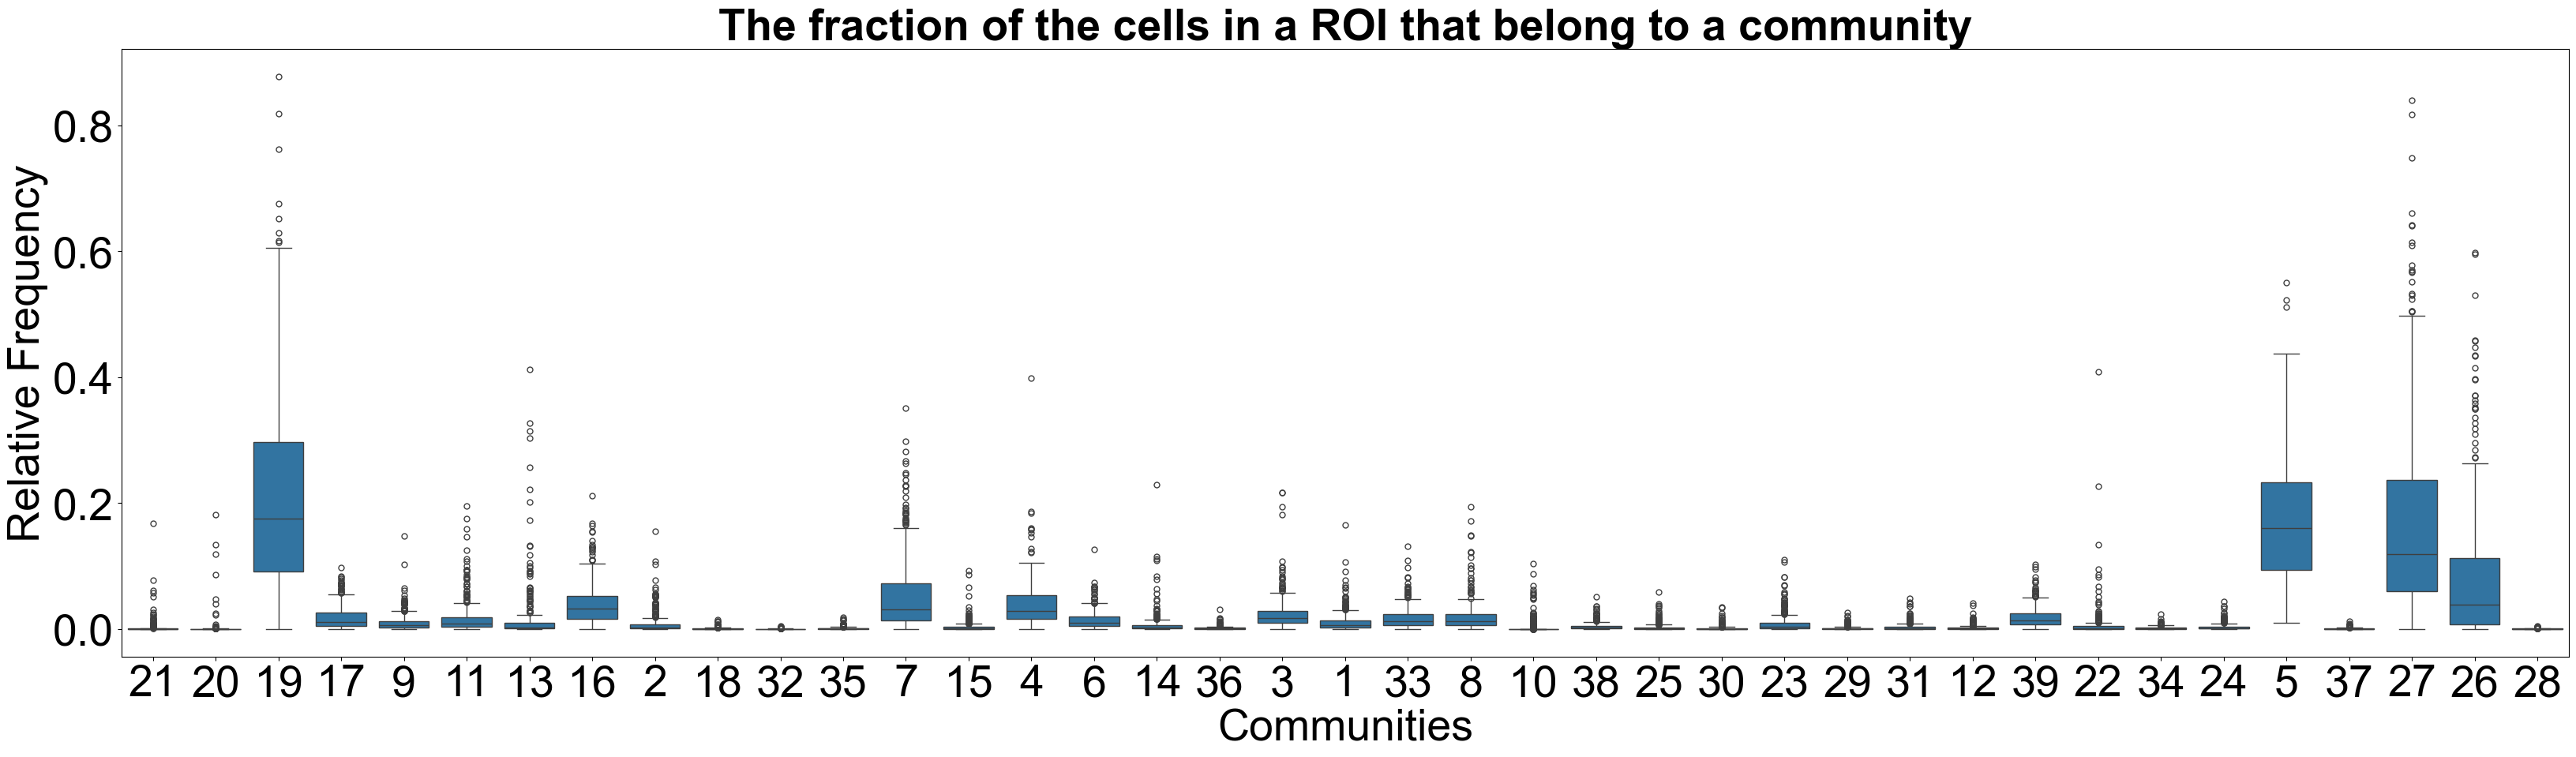

In [19]:

plt.figure(figsize=(40, 10))

sns.boxplot(data=clus_pats_freq, x='cluster', y='relative_frequency', showfliers=True, flierprops=dict(marker='o', markersize=5), order=comm_order)
plt.title('The fraction of the cells in a ROI that belong to a community', fontsize=40, fontfamily='Arial', fontweight='bold')
plt.xlabel('Communities', fontsize=40, fontfamily='Arial')
plt.ylabel('Relative Frequency', fontsize=40, fontfamily='Arial')
# Set the tick labels at specific positions to red
# locs, labels = plt.xticks()
# for tick in treg_clusters_39:
#     labels[tick-1].set_font_properties(FontProperties(weight='bold'))
# # Set the modified tick labels
# plt.xticks(locs, labels)

# plt.xlabel('Number of Clusters', fontsize=20, fontfamily='Arial', fontweight='bold')
# plt.ylabel('Loss of Variance (1e6)', fontsize=20, fontfamily='Arial', fontweight='bold')
plt.yticks( fontsize=40, fontfamily='Arial')
plt.xticks(fontsize=40, fontfamily='Arial')

plt.savefig(f'{data_path}/clustering_plots/frequencyclusters_boxplot.jpg', dpi=300)

plt.show()


In [20]:
pvals_toptreg = []
for clus in sorted(treg_clusters_40):
    df5 = boxplot_df_toptreg.loc[boxplot_df_toptreg['cluster'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_toptreg.append(pval)


# Perform Benjamini-Hochberg adjustment
pvals_toptreg_adjusted = sm.multipletests(pvals_toptreg, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_toptreg)
print("Adjusted p-values:", pvals_toptreg_adjusted)

pvals_toptreg_adjusted

Original p-values: [0.0044465113728883975, 0.16008794676296123, 0.6011781703531605, 0.4952088987342118, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.005120866752204937, 0.5690180077477516, 0.3750243797530407]
Adjusted p-values: [0.02560433 0.32017589 0.66797574 0.66797574 0.07747483 0.32017589
 0.70754681 0.02560433 0.66797574 0.62504063]


array([0.02560433, 0.32017589, 0.66797574, 0.66797574, 0.07747483,
       0.32017589, 0.70754681, 0.02560433, 0.66797574, 0.62504063])

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

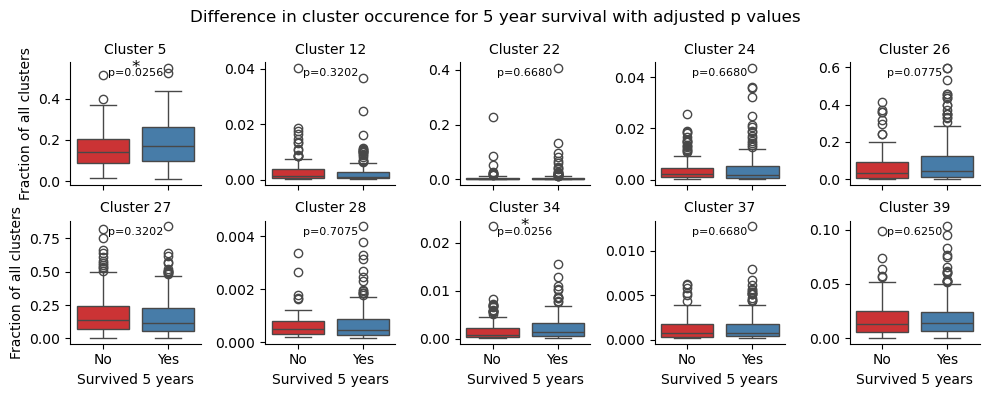

In [21]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_toptreg, col="cluster", col_wrap=5, height=2, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")

g.set_axis_labels("Survived 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('cluster')):
    p_value = pvals_toptreg_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 12)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival with adjusted p values')
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the title

# plt.savefig(f'{data_path}clustering_plots/boxplot_toptregclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
pvals_all = []
for clus in range(1, boxplot_df_all['cluster'].max() + 1):
    df5 = boxplot_df_all.loc[boxplot_df_all['cluster'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_all.append(pval)

# Perform Benjamini-Hochberg adjustment
pvals_all_adjusted= sm.multipletests(pvals_all, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_all)
print("Adjusted p-values:", pvals_all_adjusted)

# pvals_all_adjusted

Original p-values: [0.7350763326173237, 0.6874352782374415, 0.5499185156672899, 0.7042505707202609, 0.0044465113728883975, 0.42861060991522526, 0.24516598452584804, 0.04030883861828084, 0.9992401203566633, 0.6545584604838195, 0.21187846141103472, 0.16008794676296123, 0.6339282184732911, 0.9547209454344872, 0.22046537771504016, 0.5517057212119293, 0.7909142091329485, 0.10418126268767584, 0.5823214833928552, 0.019129611067836557, 0.4602260636063784, 0.6011781703531605, 0.45029657655483535, 0.4952088987342118, 0.24187133876165523, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.542422527665256, 0.7950398514983266, 0.04187722801571854, 0.30255980360278467, 0.029295661263270944, 0.005120866752204937, 0.32822610662738627, 0.1434185349486618, 0.5690180077477516, 0.5685238962036092, 0.3750243797530407]
Adjusted p-values: [0.81908506 0.81159781 0.80848099 0.81159781 0.0998569  0.80848099
 0.63743156 0.23331598 0.99924012 0.81159781 0.63743156 0.56758454
 0.81159781 0.97984518 0

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

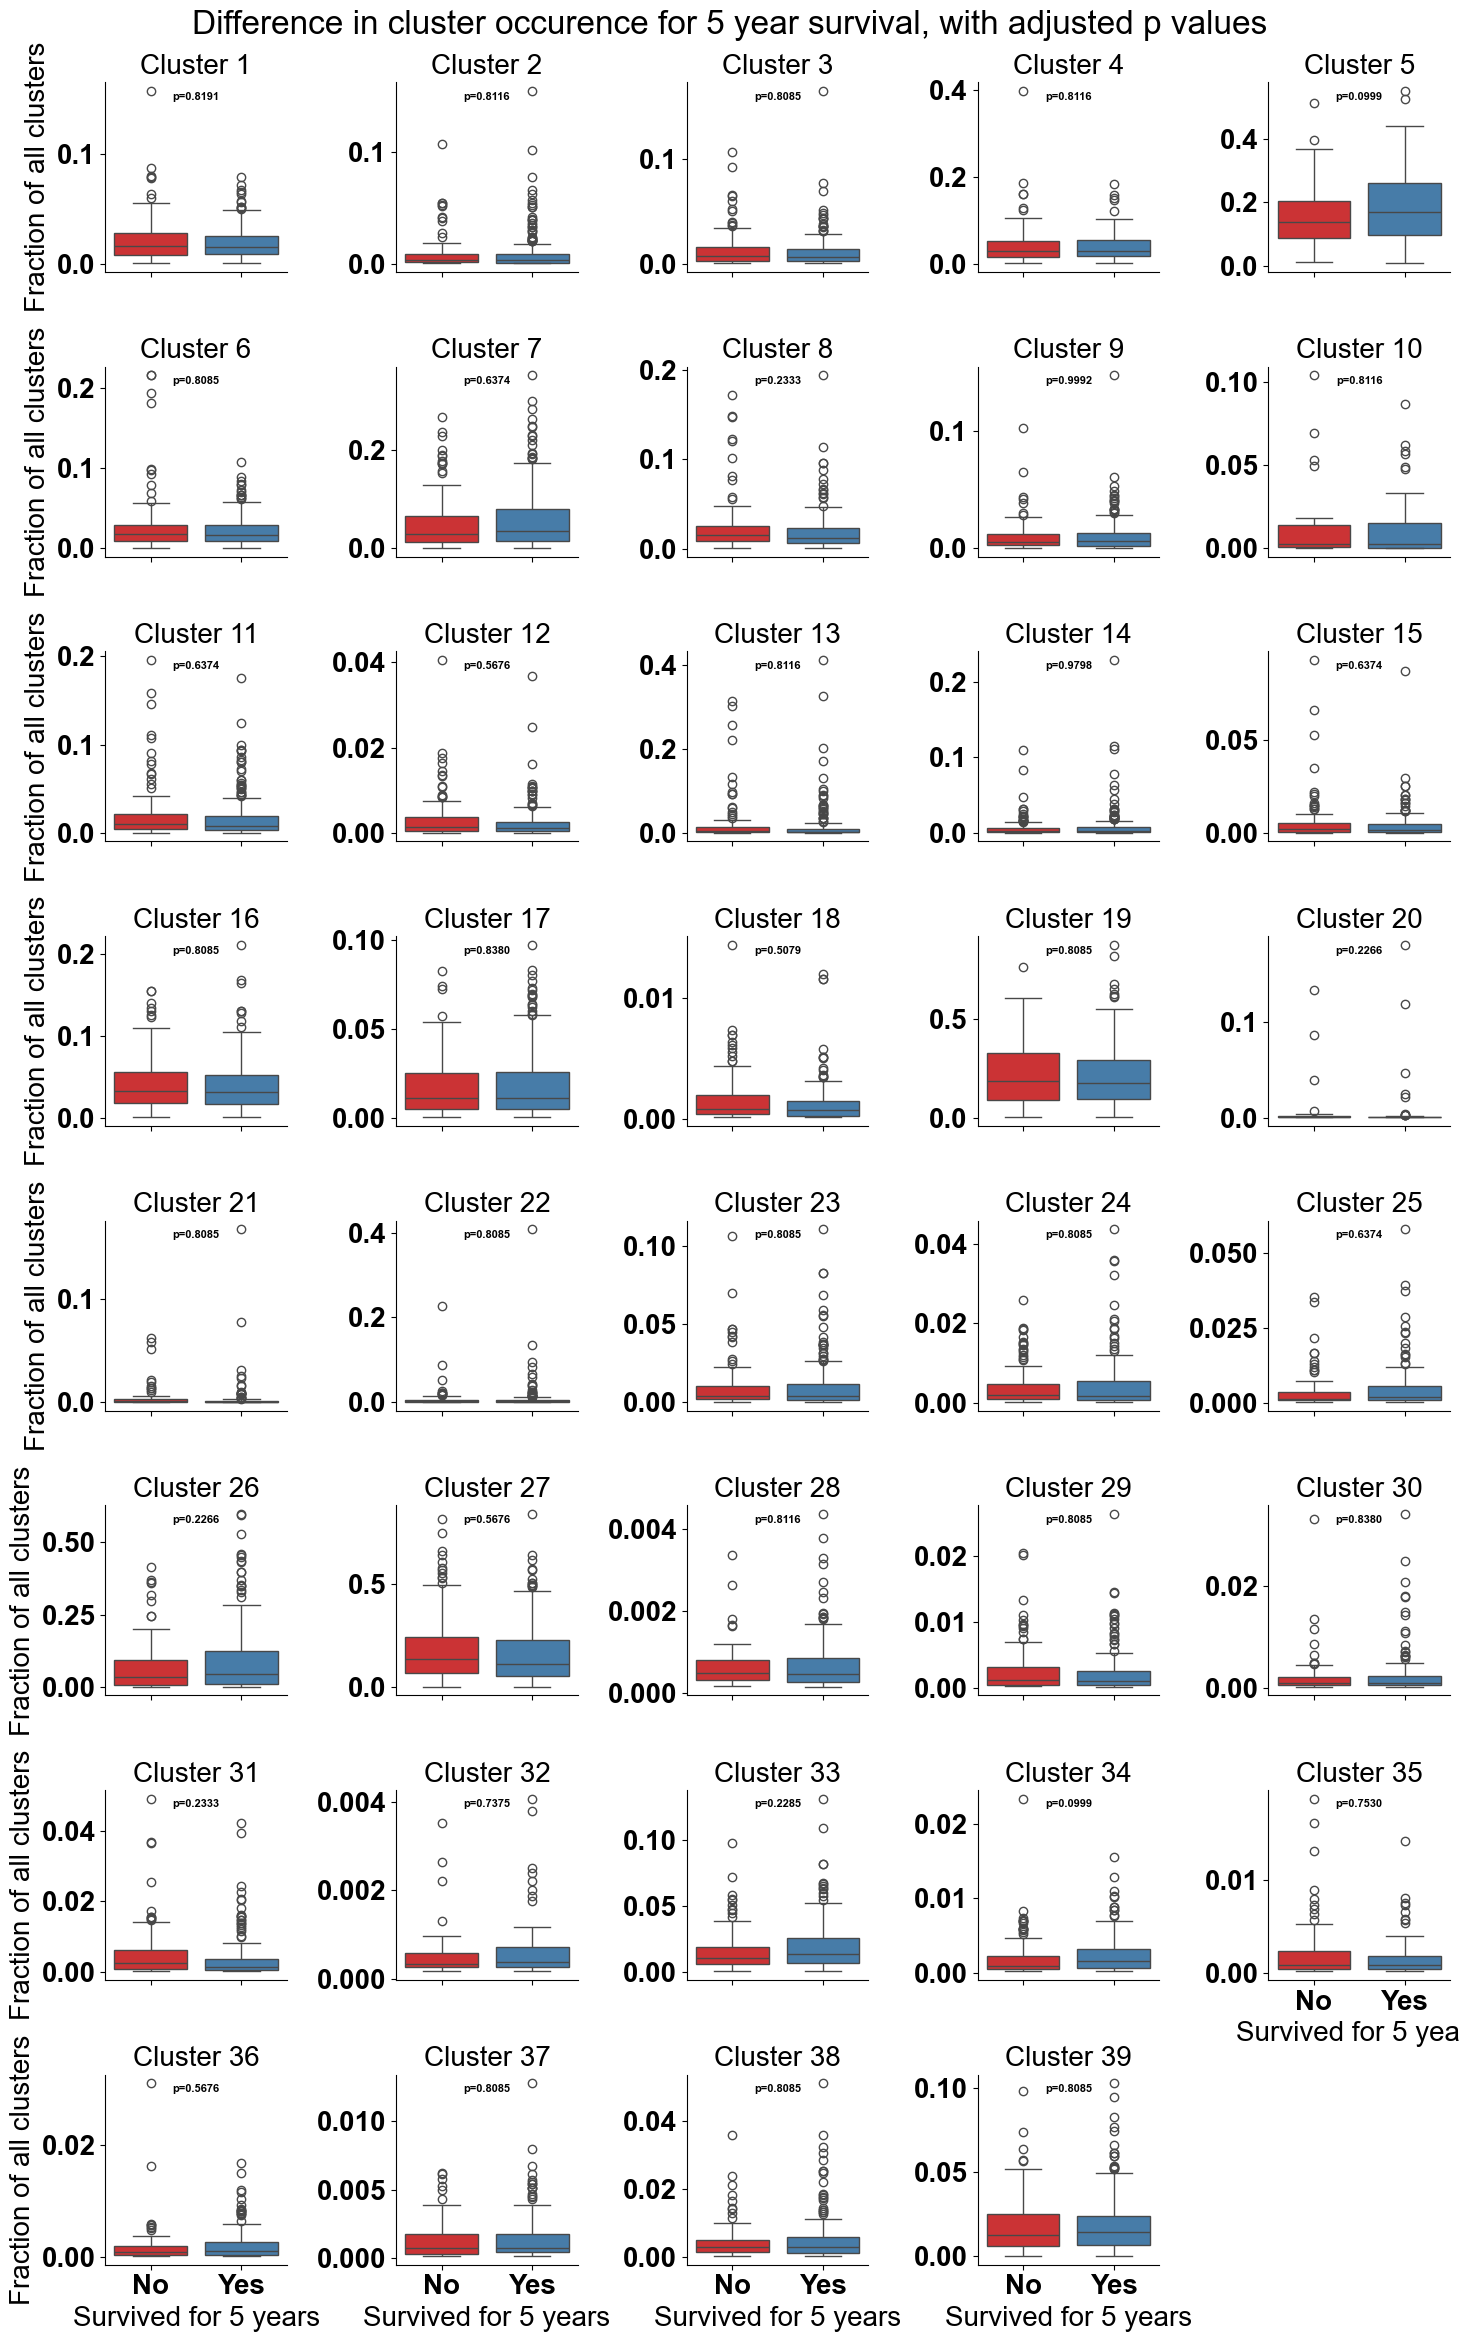

In [ ]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_all, col="cluster", col_wrap=5, height=3, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")
g.set_axis_labels("Survived for 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('cluster')):
    p_value = pvals_all_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 15)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival, with adjusted p values')
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the title

# plt.title('Difference in cluster occurence for long')
# plt.savefig(f'{data_path}clustering_plots/boxplot_allclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [22]:
# colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075', '#a9a9a9', '#000000']
# cts = ['Alt MAC', 'B cell', 'Cancer', 'Cl MAC', 'Cl Mo', 'DCs cell', 'Endothelial cell', 'Int Mo', 'Mast cell', 'NK cell', 'Neutrophils','Non-Cl Mo', 'T other', 'Tc', 'Th', 'Treg', 'Unknown'][::-1]
ct_order = ['Cancer', 'Endothelial',   'Alt_Mac', 'Cl_Mac', 'Cl_Mo','Int_Mo', 'Non-Cl_Mo', 'DC',  'Neutrophil','Mast', 'NK', 'B', 'T_other', 'Tc', 'Th', 'Treg', 'Unknown']
# colors = ['blue', 'orange', 'green', 'red', 'purple', 'maroon', 'pink', 'gray', 'yellow', 'cyan', 'magenta', 'olive', 'brown', 'navy', 'aqua', 'teal']
cell_type_colors = {
    'Cancer': '#FF0000',             # Red
    'Alt_Mac': '#0000FF',            # blue 
    'Cl_Mac': '#4169E1',             # blue
    'Cl_Mo': '#0096FF',              # blue
    'Int_Mo': '#00FFFF',             # ''
    'Non-Cl_Mo': '#87CEEB',          # ''
    'Mast': '#FFFF00',          # Yellow
    'B': '#C4A484',             # brown
    'DC': '#6A0DAD',           # purple
    'Endothelial': '#FFA500',   # Orange
    'NK': '#FFC0CB',            # pink
    'Neutrophil': '#FF00FF',        # magenta
    'T_other': '#66CDAA',            # green
    'Tc': '#008000',                 # Green
    'Th': '#2E8B57',                 # Green (similar to 'Tc')
    'Treg': '#3CB371',               # Green
    'Unknown': '#808080'             # Gray
}

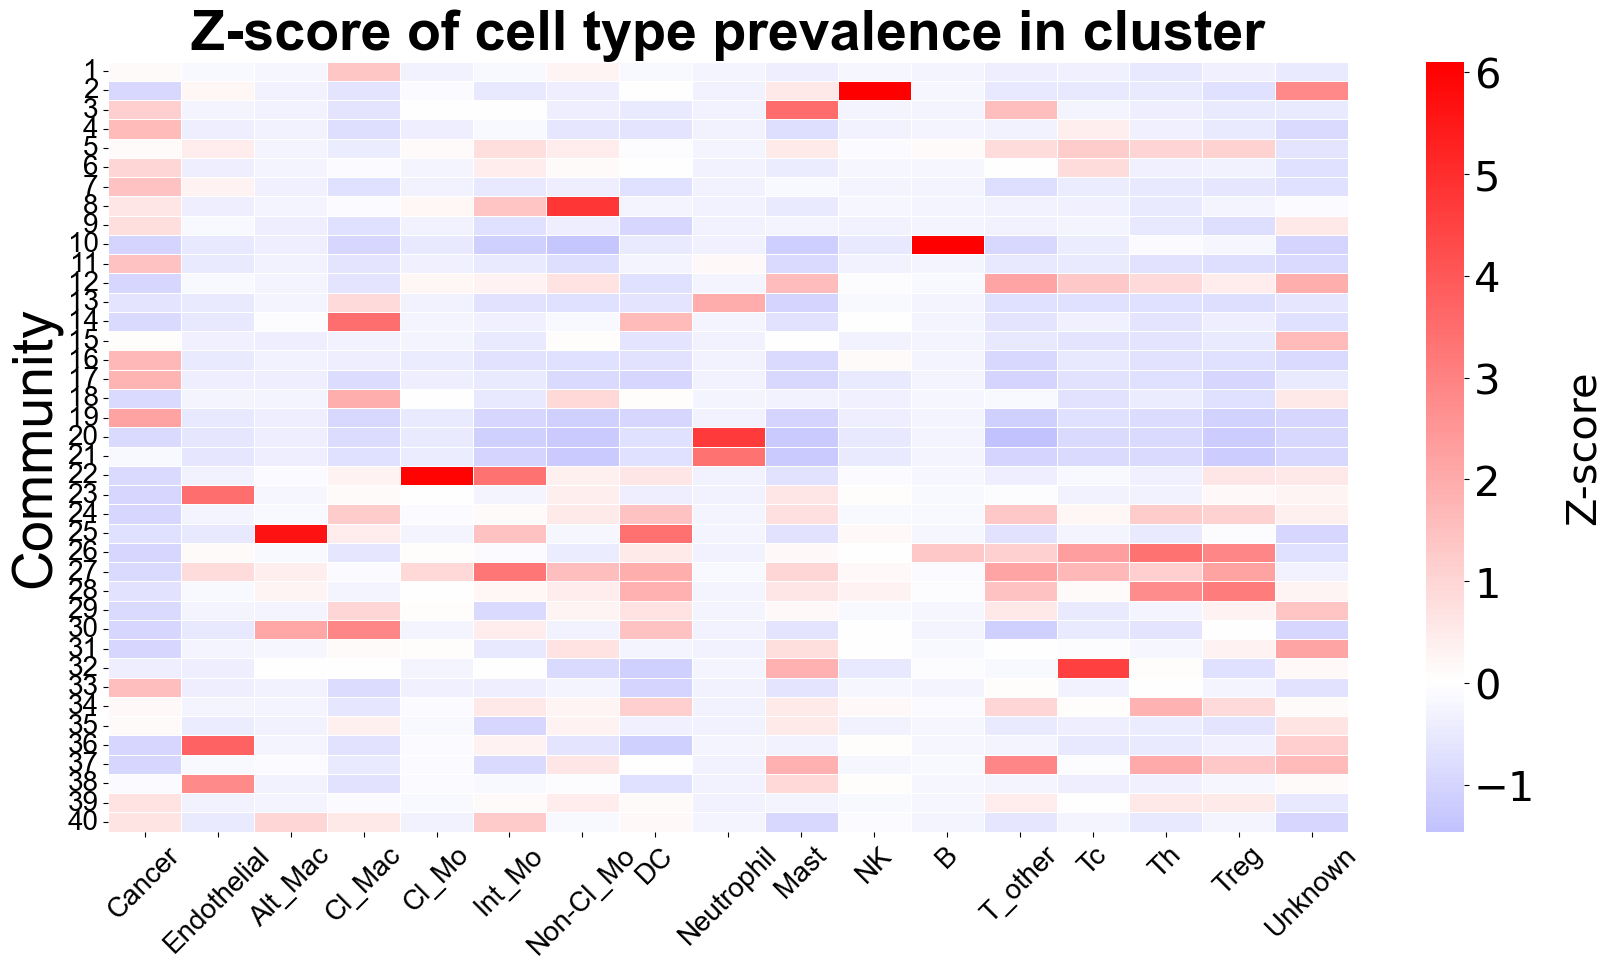

In [59]:
# Enrichtment heatmap using Z scores
grouped = df[['source_cluster', 'cluster']].groupby(['source_cluster', 'cluster']).size().unstack(fill_value=0).T
fractions = grouped.div(grouped.sum(axis=1), axis=0)
z_scores = stats.zscore(fractions, axis=0)

enrichment = z_scores

enrichment = enrichment[ct_order]
# Plot heatmap
plt.figure(figsize=(20, 10))

abs_max = np.abs(np.array(enrichment)).max()

# ax = sns.heatmap(enrichment, cmap='bwr', fmt=".2f", linewidths=.5, center=0, vmin=-abs_max, vmax=abs_max)

ax = sns.heatmap(enrichment, cmap='bwr', fmt=".2f", linewidths=.5, center=0)

plt.title('Z-score of cell type prevalence in cluster',fontsize=40, fontfamily='Arial', fontweight='bold')
plt.ylabel('Community',fontsize=40, fontfamily='Arial')
plt.xlabel('',fontsize=40, fontfamily='Arial')
plt.yticks(rotation=0, fontsize=20, fontfamily='Arial')
plt.xticks(rotation=45, fontsize=20, fontfamily='Arial')

# Edit the colorbar
cbar = ax.collections[0].colorbar

cbar.set_label('Z-score', rotation=90, labelpad=20, fontsize=30 ) 
cbar.ax.tick_params(labelsize=30)

# cbar.set_ticks([-1 ,0, 1])
plt.savefig(f"{data_path}/clustering_plots/Celltype_allclus_zscore", bbox_inches='tight')
# Show the plot
plt.show()


# plt.title('The fraction of the cells in a ROI that belong to a community', fontsize=40, fontfamily='Arial', fontweight='bold')
# plt.xlabel('Communities', fontsize=40, fontfamily='Arial')
# plt.ylabel('Relative Frequency', fontsize=40, fontfamily='Arial')




In [47]:

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


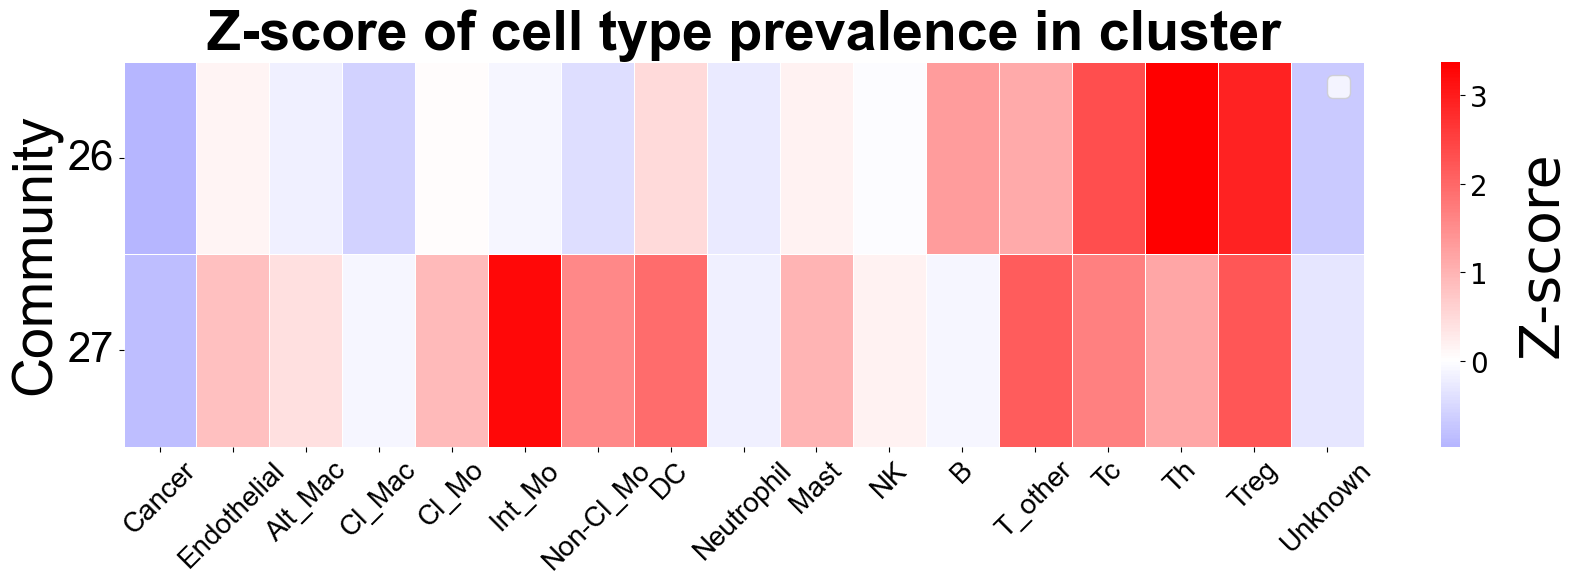

In [62]:
# Enrichtment heatmap using Z scores
grouped = df[['source_cluster', 'cluster']].groupby(['source_cluster', 'cluster']).size().unstack(fill_value=0).T
fractions = grouped.div(grouped.sum(axis=1), axis=0)
z_scores = stats.zscore(fractions, axis=0)

enrichment = z_scores

enrichment = enrichment[ct_order]
# Plot heatmap
plt.figure(figsize=(20, 5))

abs_max = np.abs(np.array(enrichment)).max()

# ax = sns.heatmap(enrichment, cmap='bwr', fmt=".2f", linewidths=.5, center=0, vmin=-abs_max, vmax=abs_max)

ax = sns.heatmap(enrichment.iloc[25:27], cmap='bwr', fmt=".2f", linewidths=.5, center=0)

plt.title('Z-score of cell type prevalence in cluster',fontsize=40, fontfamily='Arial', fontweight='bold')
plt.ylabel('Community',fontsize=40, fontfamily='Arial')
plt.xlabel('',fontsize=40, fontfamily='Arial')
plt.yticks(rotation=0, fontsize=30, fontfamily='Arial')
plt.xticks(rotation=45, fontsize=20, fontfamily='Arial')

# Edit the colorbar
cbar = ax.collections[0].colorbar

cbar.set_label('Z-score', rotation=90, labelpad=20,  size=40) 
cbar.ax.tick_params(labelsize=20)
plt.legend(prop={'size': 20, 'family': 'Arial'})

# cbar.set_ticks([-1 ,0, 1])
plt.savefig(f"{data_path}/clustering_plots/Celltype_2627_zscore", bbox_inches='tight')
# Show the plot
plt.show()